In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.style.use("seaborn")

In [3]:
file_path = "/content/NYC_Analysis.csv"
df = pd.read_csv(file_path, index_col=0)

In [4]:
df.drop(["CMPLNT_NUM"], axis=1, inplace=True) # CMPLNT_NUM is just an identifier.

In [5]:
df

,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,LOC_OF_OCCUR_DESC,OFNS_DESC,PATROL_BORO,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,Latitude,Longitude,New Georeferenced Column
5,115,QUEENS,03/24/2021,18:06:00,03/24/2021,18:10:00,COMPLETED,0.0,N.Y. POLICE DEPT,347,MISDEMEANOR,NaN,INTOXICATED & IMPAIRED DRIVING,PATROL BORO QUEENS NORTH,905.0,"INTOXICATED DRIVING,ALCOHOL",STREET,03/24/2021,25-44,BLACK,F,40.762205,-73.870405,POINT (-73.870405222 40.762204702000076)
9,34,MANHATTAN,03/18/2021,08:30:00,03/22/2021,08:05:00,COMPLETED,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,FRONT OF,PETIT LARCENY,PATROL BORO MAN NORTH,321.0,"LARCENY,PETIT FROM AUTO",STREET,03/22/2021,25-44,BLACK HISPANIC,F,40.866419,-73.921556,POINT (-73.92155642099993 40.866418569000075)
10,44,BRONX,03/21/2021,09:30:00,03/21/2021,09:40:00,COMPLETED,0.0,N.Y. POLICE DEPT,578,VIOLATION,FRONT OF,HARRASSMENT 2,PATROL BORO BRONX,638.0,"HARASSMENT,SUBD 3,4,5",STREET,03/21/2021,25-44,BLACK,F,40.831604,-73.928799,POINT (-73.92879934599993 40.83160392600007)
20,113,NaN,03/10/2021,09:00:00,NaN,NaN,COMPLETED,NaN,N.Y. POLICE DEPT,101,FELONY,OUTSIDE,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,NaN,NaN,03/10/2021,25-44,BLACK,F,40.668799,-73.785265,POINT (-73.785265338 40.66879922900005)
31,47,BRONX,03/03/2021,00:50:00,03/03/2021,01:15:00,ATTEMPTED,0.0,N.Y. POLICE DEPT,106,FELONY,INSIDE,FELONY ASSAULT,PATROL BORO BRONX,109.0,"ASSAULT 2,1,UNCLASSIFIED",FAST FOOD,03/03/2021,18-24,BLACK,F,40.879658,-73.842379,POINT (-73.84237853899998 40.879657598000044)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96714,42,BRONX,01/05/2021,04:05:00,01/05/2021,04:10:00,COMPLETED,0.0,N.Y. POLICE DEPT,121,FELONY,INSIDE,CRIMINAL MISCHIEF & RELATED OF,PATROL BORO BRONX,269.0,"MISCHIEF,CRIMINAL, UNCL 2ND",RESIDENCE - APT. HOUSE,01/05/2021,25-44,WHITE HISPANIC,F,40.827367,-73.906860,POINT (-73.90685995799998 40.82736692100008)
96719,23,MANHATTAN,01/05/2021,21:30:00,01/05/2021,21:50:00,COMPLETED,2.0,N.Y. HOUSING POLICE,106,FELONY,INSIDE,FELONY ASSAULT,PATROL BORO MAN NORTH,109.0,"ASSAULT 2,1,UNCLASSIFIED",RESIDENCE - PUBLIC HOUSING,01/06/2021,25-44,WHITE HISPANIC,F,40.788721,-73.939997,POINT (-73.93999677399995 40.788721243000055)
96723,101,QUEENS,01/02/2021,07:30:00,01/03/2021,09:00:00,COMPLETED,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,FRONT OF,PETIT LARCENY,PATROL BORO QUEENS SOUTH,321.0,"LARCENY,PETIT FROM AUTO",RESIDENCE-HOUSE,01/03/2021,25-44,AMERICAN INDIAN/ALASKAN NATIVE,F,40.607952,-73.753289,POINT (-73.75328891799995 40.607951554000074)
96727,48,BRONX,01/05/2021,18:39:00,01/05/2021,18:43:00,COMPLETED,0.0,N.Y. POLICE DEPT,109,FELONY,FRONT OF,GRAND LARCENY,PATROL BORO BRONX,409.0,"LARCENY,GRAND BY EXTORTION",RESIDENCE - APT. HOUSE,01/05/2021,25-44,BLACK HISPANIC,F,40.854120,-73.888810,POINT (-73.88880988799998 40.854120099000056)


In [6]:
date_cols = ["CMPLNT_FR_DT", "CMPLNT_TO_DT", "RPT_DT"]
pd.to_datetime(df[date_cols].stack(), format="%m/%d/%Y").unstack()

,CMPLNT_FR_DT,CMPLNT_TO_DT,RPT_DT
5,2021-03-24,2021-03-24,2021-03-24
9,2021-03-18,2021-03-22,2021-03-22
10,2021-03-21,2021-03-21,2021-03-21
20,2021-03-10,NaT,2021-03-10
31,2021-03-03,2021-03-03,2021-03-03
...,...,...,...
96714,2021-01-05,2021-01-05,2021-01-05
96719,2021-01-05,2021-01-05,2021-01-06
96723,2021-01-02,2021-01-03,2021-01-03
96727,2021-01-05,2021-01-05,2021-01-05


In [7]:
# Preparing data

# Combine date and time columns
orig_date_fr_cols = ["CMPLNT_FR_DT", "CMPLNT_FR_TM"]
df["CMPLNT_FR_DTM"] = df[orig_date_fr_cols].apply(lambda x: " ".join(x), axis=1)
df.drop(orig_date_fr_cols, axis=1, inplace=True)

In [8]:
# One hot encoding the target variable (`LAW_CAT_CD`)
from sklearn.preprocessing import LabelEncoder
y = df["LAW_CAT_CD"]
le = LabelEncoder()
series = le.fit_transform(y)

df["Target"] = series
df.drop("LAW_CAT_CD", axis=1, inplace=True)

In [9]:
categorical_features = ["BORO_NM", "CRM_ATPT_CPTD_CD", "JURIS_DESC", "LOC_OF_OCCUR_DESC", 
                "OFNS_DESC", "PATROL_BORO", "PD_DESC", "PREM_TYP_DESC", 
                "VIC_AGE_GROUP", "VIC_RACE", "VIC_SEX"
              ]
categorical_targets = ["LAW_CAT_CD"]

df = pd.get_dummies(df, columns=categorical_features)

In [10]:
df # The `Target` column is the one-hot encoded version of LAW_CT_CD

,ADDR_PCT_CD,CMPLNT_TO_DT,CMPLNT_TO_TM,JURISDICTION_CODE,KY_CD,PD_CD,RPT_DT,Latitude,Longitude,New Georeferenced Column,CMPLNT_FR_DTM,Target,BORO_NM_BRONX,BORO_NM_BROOKLYN,BORO_NM_MANHATTAN,BORO_NM_QUEENS,BORO_NM_STATEN ISLAND,CRM_ATPT_CPTD_CD_ATTEMPTED,CRM_ATPT_CPTD_CD_COMPLETED,JURIS_DESC_DEPT OF CORRECTIONS,JURIS_DESC_HEALTH & HOSP CORP,JURIS_DESC_METRO NORTH,JURIS_DESC_N.Y. HOUSING POLICE,JURIS_DESC_N.Y. POLICE DEPT,JURIS_DESC_N.Y. STATE POLICE,JURIS_DESC_N.Y. TRANSIT POLICE,JURIS_DESC_NYC PARKS,JURIS_DESC_OTHER,JURIS_DESC_PORT AUTHORITY,JURIS_DESC_TRI-BORO BRDG TUNNL,LOC_OF_OCCUR_DESC_FRONT OF,LOC_OF_OCCUR_DESC_INSIDE,LOC_OF_OCCUR_DESC_OPPOSITE OF,LOC_OF_OCCUR_DESC_OUTSIDE,LOC_OF_OCCUR_DESC_REAR OF,OFNS_DESC_ADMINISTRATIVE CODE,OFNS_DESC_AGRICULTURE & MRKTS LAW-UNCLASSIFIED,OFNS_DESC_ARSON,OFNS_DESC_ASSAULT 3 & RELATED OFFENSES,OFNS_DESC_BURGLARY,...,PREM_TYP_DESC_MAILBOX INSIDE,PREM_TYP_DESC_MAILBOX OUTSIDE,PREM_TYP_DESC_OPEN AREAS (OPEN LOTS),PREM_TYP_DESC_OTHER,PREM_TYP_DESC_OTHER HOUSE OF WORSHIP,PREM_TYP_DESC_PARK/PLAYGROUND,PREM_TYP_DESC_PARKING LOT/GARAGE (PRIVATE),PREM_TYP_DESC_PARKING LOT/GARAGE (PUBLIC),PREM_TYP_DESC_PHOTO/COPY,PREM_TYP_DESC_PRIVATE/PAROCHIAL SCHOOL,PREM_TYP_DESC_PUBLIC BUILDING,PREM_TYP_DESC_PUBLIC SCHOOL,PREM_TYP_DESC_RESIDENCE - APT. HOUSE,PREM_TYP_DESC_RESIDENCE - PUBLIC HOUSING,PREM_TYP_DESC_RESIDENCE-HOUSE,PREM_TYP_DESC_RESTAURANT/DINER,PREM_TYP_DESC_SMALL MERCHANT,PREM_TYP_DESC_SOCIAL CLUB/POLICY,PREM_TYP_DESC_STORAGE FACILITY,PREM_TYP_DESC_STORE UNCLASSIFIED,PREM_TYP_DESC_STREET,PREM_TYP_DESC_TAXI (LIVERY LICENSED),PREM_TYP_DESC_TAXI (YELLOW LICENSED),PREM_TYP_DESC_TAXI/LIVERY (UNLICENSED),PREM_TYP_DESC_TELECOMM. STORE,PREM_TYP_DESC_TRANSIT - NYC SUBWAY,PREM_TYP_DESC_TRANSIT FACILITY (OTHER),PREM_TYP_DESC_TUNNEL,PREM_TYP_DESC_VARIETY STORE,PREM_TYP_DESC_VIDEO STORE,VIC_AGE_GROUP_18-24,VIC_AGE_GROUP_25-44,VIC_RACE_AMERICAN INDIAN/ALASKAN NATIVE,VIC_RACE_ASIAN / PACIFIC ISLANDER,VIC_RACE_BLACK,VIC_RACE_BLACK HISPANIC,VIC_RACE_UNKNOWN,VIC_RACE_WHITE,VIC_RACE_WHITE HISPANIC,VIC_SEX_F
5,115,03/24/2021,18:10:00,0.0,347,905.0,03/24/2021,40.762205,-73.870405,POINT (-73.870405222 40.762204702000076),03/24/2021 18:06:00,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
9,34,03/22/2021,08:05:00,0.0,341,321.0,03/22/2021,40.866419,-73.921556,POINT (-73.92155642099993 40.866418569000075),03/18/2021 08:30:00,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
10,44,03/21/2021,09:40:00,0.0,578,638.0,03/21/2021,40.831604,-73.928799,POINT (-73.92879934599993 40.83160392600007),03/21/2021 09:30:00,2,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
20,113,NaN,NaN,NaN,101,NaN,03/10/2021,40.668799,-73.785265,POINT (-73.785265338 40.66879922900005),03/10/2021 09:00:00,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
31,47,03/03/2021,01:15:00,0.0,106,109.0,03/03/2021,40.879658,-73.842379,POINT (-73.84237853899998 40.879657598000044),03/03/2021 00:50:00,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96714,42,01/05/2021,04:10:00,0.0,121,269.0,01/05/2021,40.827367,-73.906860,POINT (-73.90685995799998 40.82736692100008),01/05/2021 04:05:00,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0

In [11]:
date_cols = ["CMPLNT_TO_DT", "CMPLNT_TO_TM", "RPT_DT", "CMPLNT_FR_DTM"]
new_df = df.drop(date_cols, axis=1)

additional_drop_cols = ["New Georeferenced Column"]
new_df.drop(additional_drop_cols, axis=1, inplace=True)

check_drop_cols = ["JURISDICTION_CODE", "PD_CD"]
new_df.drop(check_drop_cols, axis=1, inplace=True)

In [12]:
new_df

,ADDR_PCT_CD,KY_CD,Latitude,Longitude,Target,BORO_NM_BRONX,BORO_NM_BROOKLYN,BORO_NM_MANHATTAN,BORO_NM_QUEENS,BORO_NM_STATEN ISLAND,CRM_ATPT_CPTD_CD_ATTEMPTED,CRM_ATPT_CPTD_CD_COMPLETED,JURIS_DESC_DEPT OF CORRECTIONS,JURIS_DESC_HEALTH & HOSP CORP,JURIS_DESC_METRO NORTH,JURIS_DESC_N.Y. HOUSING POLICE,JURIS_DESC_N.Y. POLICE DEPT,JURIS_DESC_N.Y. STATE POLICE,JURIS_DESC_N.Y. TRANSIT POLICE,JURIS_DESC_NYC PARKS,JURIS_DESC_OTHER,JURIS_DESC_PORT AUTHORITY,JURIS_DESC_TRI-BORO BRDG TUNNL,LOC_OF_OCCUR_DESC_FRONT OF,LOC_OF_OCCUR_DESC_INSIDE,LOC_OF_OCCUR_DESC_OPPOSITE OF,LOC_OF_OCCUR_DESC_OUTSIDE,LOC_OF_OCCUR_DESC_REAR OF,OFNS_DESC_ADMINISTRATIVE CODE,OFNS_DESC_AGRICULTURE & MRKTS LAW-UNCLASSIFIED,OFNS_DESC_ARSON,OFNS_DESC_ASSAULT 3 & RELATED OFFENSES,OFNS_DESC_BURGLARY,OFNS_DESC_CRIMINAL MISCHIEF & RELATED OF,OFNS_DESC_CRIMINAL TRESPASS,OFNS_DESC_DANGEROUS DRUGS,OFNS_DESC_DANGEROUS WEAPONS,OFNS_DESC_FELONY ASSAULT,OFNS_DESC_FORGERY,OFNS_DESC_FRAUDS,...,PREM_TYP_DESC_MAILBOX INSIDE,PREM_TYP_DESC_MAILBOX OUTSIDE,PREM_TYP_DESC_OPEN AREAS (OPEN LOTS),PREM_TYP_DESC_OTHER,PREM_TYP_DESC_OTHER HOUSE OF WORSHIP,PREM_TYP_DESC_PARK/PLAYGROUND,PREM_TYP_DESC_PARKING LOT/GARAGE (PRIVATE),PREM_TYP_DESC_PARKING LOT/GARAGE (PUBLIC),PREM_TYP_DESC_PHOTO/COPY,PREM_TYP_DESC_PRIVATE/PAROCHIAL SCHOOL,PREM_TYP_DESC_PUBLIC BUILDING,PREM_TYP_DESC_PUBLIC SCHOOL,PREM_TYP_DESC_RESIDENCE - APT. HOUSE,PREM_TYP_DESC_RESIDENCE - PUBLIC HOUSING,PREM_TYP_DESC_RESIDENCE-HOUSE,PREM_TYP_DESC_RESTAURANT/DINER,PREM_TYP_DESC_SMALL MERCHANT,PREM_TYP_DESC_SOCIAL CLUB/POLICY,PREM_TYP_DESC_STORAGE FACILITY,PREM_TYP_DESC_STORE UNCLASSIFIED,PREM_TYP_DESC_STREET,PREM_TYP_DESC_TAXI (LIVERY LICENSED),PREM_TYP_DESC_TAXI (YELLOW LICENSED),PREM_TYP_DESC_TAXI/LIVERY (UNLICENSED),PREM_TYP_DESC_TELECOMM. STORE,PREM_TYP_DESC_TRANSIT - NYC SUBWAY,PREM_TYP_DESC_TRANSIT FACILITY (OTHER),PREM_TYP_DESC_TUNNEL,PREM_TYP_DESC_VARIETY STORE,PREM_TYP_DESC_VIDEO STORE,VIC_AGE_GROUP_18-24,VIC_AGE_GROUP_25-44,VIC_RACE_AMERICAN INDIAN/ALASKAN NATIVE,VIC_RACE_ASIAN / PACIFIC ISLANDER,VIC_RACE_BLACK,VIC_RACE_BLACK HISPANIC,VIC_RACE_UNKNOWN,VIC_RACE_WHITE,VIC_RACE_WHITE HISPANIC,VIC_SEX_F
5,115,347,40.762205,-73.870405,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
9,34,341,40.866419,-73.921556,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
10,44,578,40.831604,-73.928799,2,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
20,113,101,40.668799,-73.785265,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
31,47,106,40.879658,-73.842379,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96714,42,121,40.827367,-73.906860,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
96719,23,106,40.788721,-73.939997,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
96723,101,341,40.607952,-73.753289,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
96727,48,109,40.854120,-

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
new_df = new_df.rename(columns={"SUSP_AGE_GROUP_<18": "SUSP_AGE_GROUP_less_than_18"})

In [15]:
X = new_df.drop("Target", axis=1)
y = new_df["Target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [16]:
from sklearn.cluster import KMeans

In [17]:
kmeans = KMeans(n_clusters=3)

In [18]:
kmeans.fit(X_train, y_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [19]:
cluster_centers = kmeans.cluster_centers_

In [20]:
from sklearn.metrics import confusion_matrix, classification_report

In [21]:
print(confusion_matrix(y_train, kmeans.labels_))
print("\n")
print("\n")
print(classification_report(y_train, kmeans.labels_))

[[   0 4523    0]
 [8214    0    0]
 [   0    0 4450]]




              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4523
           1       0.00      0.00      0.00      8214
           2       1.00      1.00      1.00      4450

    accuracy                           0.26     17187
   macro avg       0.33      0.33      0.33     17187
weighted avg       0.26      0.26      0.26     17187



In [22]:
cluster_centers

array([[6.42835403e+01, 3.43886900e+02, 4.07401568e+01, ...,
        1.61066472e-01, 2.67713660e-01, 1.00000000e+00],
       [6.59131108e+01, 1.12191908e+02, 4.07342925e+01, ...,
        1.81295600e-01, 2.64647358e-01, 1.00000000e+00],
       [6.75269663e+01, 5.78247191e+02, 4.07325243e+01, ...,
        1.38426966e-01, 2.68089888e-01, 1.00000000e+00]])

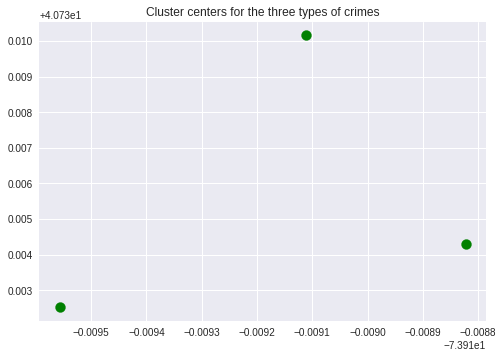

In [24]:
points = list(zip(cluster_centers[:, 3], cluster_centers[:, 2]))
plt.title("Cluster centers for the three types of crimes")
for point in points:
  plt.scatter(point[0], point[1], c="green", s=100)
plt.show()